# Fashion-MNIST classification

In [1]:
import time

import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
train_set = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=True, download=True)
test_set = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=False, download=True)

In [4]:
labels = [
    'top', 'trousers', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [5]:
# Print some kind of data sets summary
print(train_set)
print(test_set)

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../data/fashion-mnist
    Transforms (if any): None
    Target Transforms (if any): None
Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../data/fashion-mnist
    Transforms (if any): None
    Target Transforms (if any): None


In [6]:
train_x = np.array(train_set.train_data)
train_y = np.array(train_set.train_labels)

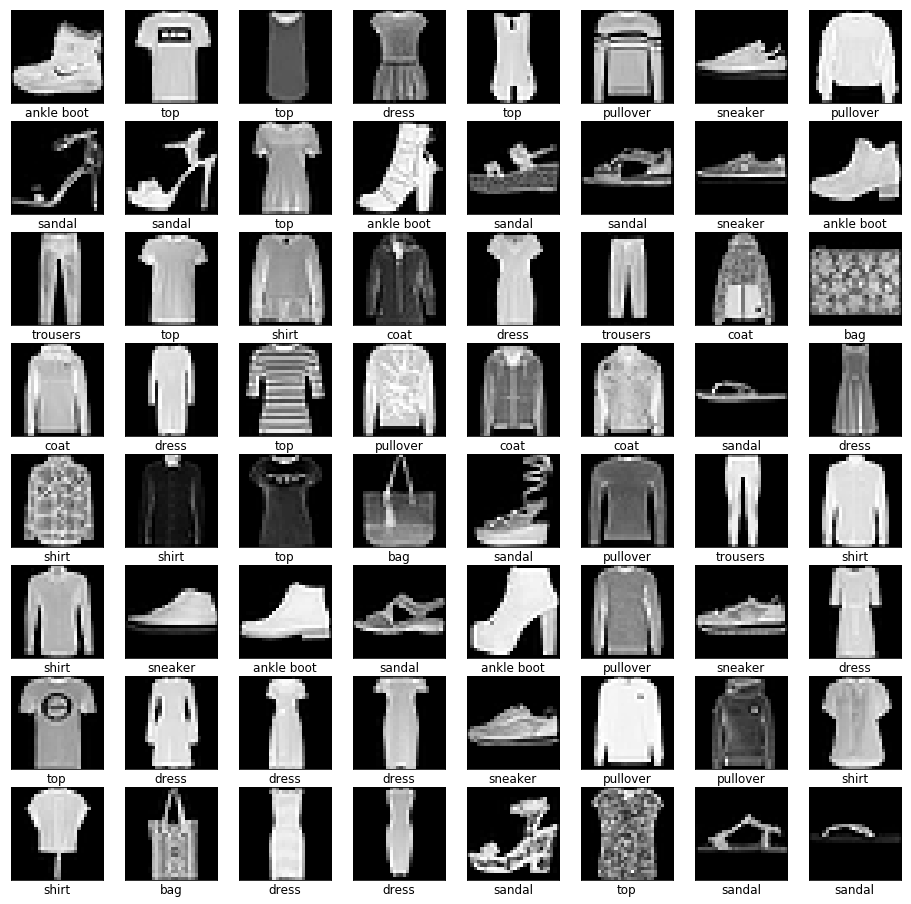

In [7]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(train_x[i], cmap=plt.cm.gray)
    plt.xlabel(labels[train_y[i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

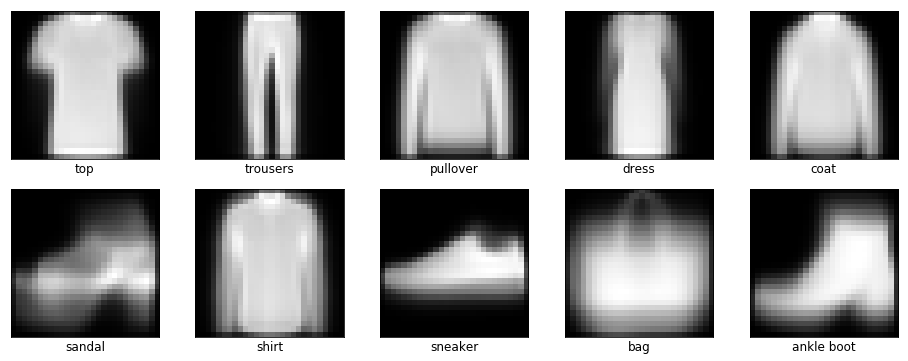

In [8]:
centroids = [(labels[i], np.mean(train_x[train_y == i], axis=0)) for i, _ in enumerate(labels)]

plt.figure(figsize=(16, 6))
for i, (label, image) in enumerate(centroids):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.xlabel(label)
    plt.xticks([])
    plt.yticks([])
plt.show()

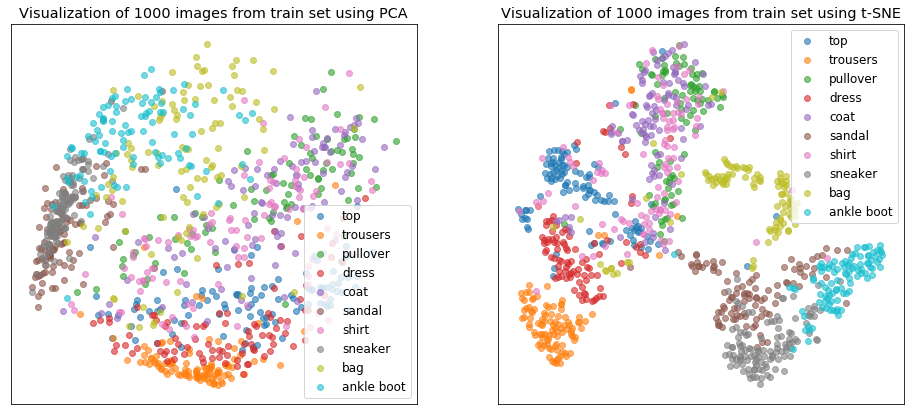

In [9]:
plt.figure(figsize=(16, 7))
for i, (algorithm_name, algorithm) in enumerate([
        ('PCA', PCA(n_components=2)), ('t-SNE', TSNE(n_components=2))]):
    x = algorithm.fit_transform(train_x[:1000].reshape(-1, 784))
    y = train_y[:1000]
    data = [(labels[i], x[y == i]) for i, _ in enumerate(labels)]
    
    plt.subplot(1, 2, i + 1)
    for label, points in data:
        plt.scatter(points[:, 0], points[:, 1], alpha=0.6, label=label)
    plt.title(f'Visualization of 1000 images from train set using {algorithm_name}')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
plt.show()

In [10]:
data_set = torchvision.datasets.FashionMNIST(
        root='../data/fashion-mnist',
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(data_set, list(range(55000))),
    batch_size=250, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(data_set, list(range(55000, 60000))),
    batch_size=250)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(
        root='../data/fashion-mnist',
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()),
    batch_size=250)

In [11]:
class Classifier(torch.nn.Module):

    def __init__(self):
        super(Classifier, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def fit(self, train_loader, val_loader, epochs):
        self.to(self.device)
        for i in range(epochs):
            self.train()
            start_time = time.time()
            loss, acc = 0, 0
            for data, target in train_loader:
                self.optimizer.zero_grad()
                data, target = data.to(self.device), target.to(self.device)
                output = self(data)
                loss_ = self.loss(output, target)
                loss += float(loss_) * len(data)
                acc += int((output.argmax(dim=1) == target).sum())
                loss_.backward()
                self.optimizer.step()
            loss /= len(train_loader.dataset)
            acc /= len(train_loader.dataset)
            val_loss, val_acc = self.evaluate(val_loader)
            duration = time.time() - start_time
            print(
                f'[{i + 1:2}/50] {duration:4.1f}s - loss: {loss:.4f} - acc: {acc:.4f}'
                f' - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}')

    def evaluate(self, data_loader):
        self.to(self.device)
        self.eval()
        loss, acc = 0, 0
        for data, target in data_loader:
            data, target = data.to(self.device), target.to(self.device)
            output = self(data)
            loss += float(self.loss(output, target)) * len(data)
            acc += int((output.argmax(dim=1) == target).sum())
        loss /= len(data_loader.dataset)
        acc /= len(data_loader.dataset)
        return loss, acc

In [12]:
class Model(Classifier):

    def __init__(self):
        super(Model, self).__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.25),
            torch.nn.Linear(784, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(150, 10),
#             torch.nn.Softmax(dim=1)
        ])
        
        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [13]:
model = Model()

In [14]:
model.fit(train_loader, val_loader, epochs=50)

[ 1/50]  4.0s - loss: 0.7408 - acc: 0.7481 - val_loss: 0.4864 - val_acc: 0.8306
[ 2/50]  4.0s - loss: 0.5134 - acc: 0.8200 - val_loss: 0.4335 - val_acc: 0.8426
[ 3/50]  3.9s - loss: 0.4673 - acc: 0.8347 - val_loss: 0.3958 - val_acc: 0.8584
[ 4/50]  3.8s - loss: 0.4372 - acc: 0.8430 - val_loss: 0.3748 - val_acc: 0.8640
[ 5/50]  3.9s - loss: 0.4192 - acc: 0.8479 - val_loss: 0.3705 - val_acc: 0.8648
[ 6/50]  3.9s - loss: 0.4039 - acc: 0.8538 - val_loss: 0.3574 - val_acc: 0.8736
[ 7/50]  3.9s - loss: 0.3961 - acc: 0.8561 - val_loss: 0.3564 - val_acc: 0.8696
[ 8/50]  3.8s - loss: 0.3826 - acc: 0.8620 - val_loss: 0.3398 - val_acc: 0.8796
[ 9/50]  3.9s - loss: 0.3750 - acc: 0.8635 - val_loss: 0.3404 - val_acc: 0.8792
[10/50]  3.8s - loss: 0.3662 - acc: 0.8651 - val_loss: 0.3305 - val_acc: 0.8816
[11/50]  3.8s - loss: 0.3635 - acc: 0.8674 - val_loss: 0.3281 - val_acc: 0.8790
[12/50]  3.9s - loss: 0.3566 - acc: 0.8684 - val_loss: 0.3265 - val_acc: 0.8802
[13/50]  3.9s - loss: 0.3523 - acc: 0.87

In [15]:
print(f'Train set accuracy:      {model.evaluate(train_loader)[1]:.4f}')
print(f'Validation set accuracy: {model.evaluate(val_loader)[1]:.4f}')
print(f'Test set accuracy:       {model.evaluate(test_loader)[1]:.4f}')

Train set accuracy:      0.9217
Validation set accuracy: 0.8892
Test set accuracy:       0.8837


In [16]:
class Model(Classifier):

    def __init__(self):
        super(Model, self).__init__()
        self.conv_layers = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 32, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        ])
        self.dense_layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(150, 10),
#             torch.nn.Softmax(dim=1),
        ])

        self.loss = torch.nn.functional.cross_entropy
        self.optimizer = torch.optim.Adam(self.parameters())

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size()[0], -1)
        for layer in self.dense_layers:
            x = layer(x)
        return x

In [17]:
model = Model()

In [18]:
model.fit(train_loader, val_loader, epochs=50)

[ 1/50]  4.8s - loss: 0.9416 - acc: 0.6522 - val_loss: 0.5391 - val_acc: 0.7906
[ 2/50]  4.8s - loss: 0.5804 - acc: 0.7871 - val_loss: 0.4410 - val_acc: 0.8348
[ 3/50]  4.8s - loss: 0.4983 - acc: 0.8181 - val_loss: 0.4001 - val_acc: 0.8500
[ 4/50]  4.9s - loss: 0.4488 - acc: 0.8376 - val_loss: 0.3612 - val_acc: 0.8672
[ 5/50]  4.8s - loss: 0.4174 - acc: 0.8498 - val_loss: 0.3537 - val_acc: 0.8676
[ 6/50]  4.7s - loss: 0.3901 - acc: 0.8594 - val_loss: 0.3184 - val_acc: 0.8806
[ 7/50]  4.8s - loss: 0.3750 - acc: 0.8643 - val_loss: 0.3127 - val_acc: 0.8866
[ 8/50]  4.8s - loss: 0.3553 - acc: 0.8720 - val_loss: 0.3026 - val_acc: 0.8890
[ 9/50]  4.8s - loss: 0.3467 - acc: 0.8750 - val_loss: 0.2977 - val_acc: 0.8878
[10/50]  4.8s - loss: 0.3320 - acc: 0.8805 - val_loss: 0.3016 - val_acc: 0.8872
[11/50]  4.8s - loss: 0.3198 - acc: 0.8838 - val_loss: 0.2878 - val_acc: 0.8920
[12/50]  4.8s - loss: 0.3171 - acc: 0.8855 - val_loss: 0.2751 - val_acc: 0.8956
[13/50]  4.8s - loss: 0.3064 - acc: 0.88

In [19]:
print(f'Train set accuracy:      {model.evaluate(train_loader)[1]:.4f}')
print(f'Validation set accuracy: {model.evaluate(val_loader)[1]:.4f}')
print(f'Test set accuracy:       {model.evaluate(test_loader)[1]:.4f}')

Train set accuracy:      0.9563
Validation set accuracy: 0.9132
Test set accuracy:       0.9101
